<a href="https://colab.research.google.com/github/Cknowles11/DS-Unit-2-Applied-Modeling/blob/master/Copy_of_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [2]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [3]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size = .8, test_size = .2, stratify = train['Fail'], random_state = 21)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [4]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
20583,1946366,SUBWAY 1121,SUBWAY,1543248.0,Restaurant,Risk 1 (High),2938 N BROADWAY,CHICAGO,IL,60657.0,2016-07-12T00:00:00,Canvass,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.936049,-87.644410,"{'longitude': '-87.64440998140738', 'latitude'...",1
9515,1196237,"UPTOWN SHOP & SAVE INC.,",UPTOWN SHOP & SAVE,2048920.0,Grocery Store,Risk 1 (High),4605 N SHERIDAN RD,CHICAGO,IL,60640.0,2012-03-30T00:00:00,Suspected Food Poisoning,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.965584,-87.654643,"{'longitude': '-87.65464343280085', 'latitude'...",0
15604,1285527,THE GROVE RESTAURANT,THE GROVE RESTAURANT,1682445.0,Restaurant,Risk 1 (High),501 W DIVERSEY PKWY,CHICAGO,IL,60614.0,2012-09-26T00:00:00,Short Form Complaint,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.932757,-87.641488,"{'longitude': '-87.6414877332763', 'latitude':...",0
40204,1983158,Burke,Burke,22411.0,School,Risk 1 (High),5356 S DR MARTIN LUTHER KING JR DR,CHICAGO,IL,60615.0,2017-02-15T00:00:00,Canvass Re-Inspection,13. NO EVIDENCE OF RODENT OR INSECT INFESTATIO...,41.796793,-87.616178,"{'longitude': '-87.61617809193172', 'latitude'...",1
41873,1632432,CLUB LAGO,CLUB LAGO,7025.0,Restaurant,Risk 1 (High),331 W SUPERIOR ST,CHICAGO,IL,60654.0,2016-03-01T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.895445,-87.637071,"{'longitude': '-87.63707141187533', 'latitude'...",0


In [5]:
import pandas_profiling

from pandas_profiling import ProfileReport

profile = ProfileReport(train, minimal = True).to_notebook_iframe()
profile

In [6]:
import numpy as np
def cleaning(D):
  D = D.copy()

  D['Inspection Date'] = pd.to_datetime(D['Inspection Date'], infer_datetime_format=True)
  D['year_recorded'] = D['Inspection Date'].dt.year
  D['month_recorded'] = D['Inspection Date'].dt.month
  D['day_recorded'] = D['Inspection Date'].dt.day
  D = D.drop(columns = 'Inspection Date')

  dropp = ['AKA Name', 'Location']
  D = D.drop(columns = dropp)

  D['lat_long'] = D['Latitude'].map(str) + "," + D['Longitude'].map(str)

  return D

In [7]:
train = cleaning(train)
test = cleaning(test)
val = cleaning(val)

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [8]:
target = 'Fail'
features = train.columns.drop(target)
X_train = train[features]
X_val = val[features]
X_test = test[features]
y_train = train[target]
y_val = val[target]
y_test = test[target]

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
process =make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'median')
)

X_train_processed =process.fit_transform(X_train)
X_val_processed = process.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(
    n_estimators = 1000,
    learning_rate = .5,
    max_depth = 15
)

model.fit(X_train_processed, y_train,
          eval_set = eval_set,
          eval_metric = 'auc',
          early_stopping_rounds = 50)

[0]	validation_0-auc:0.858012	validation_1-auc:0.559126
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.903347	validation_1-auc:0.594386
[2]	validation_0-auc:0.927789	validation_1-auc:0.593764
[3]	validation_0-auc:0.945803	validation_1-auc:0.59128
[4]	validation_0-auc:0.959396	validation_1-auc:0.591376
[5]	validation_0-auc:0.969531	validation_1-auc:0.596158
[6]	validation_0-auc:0.975322	validation_1-auc:0.600631
[7]	validation_0-auc:0.98202	validation_1-auc:0.607651
[8]	validation_0-auc:0.985115	validation_1-auc:0.608711
[9]	validation_0-auc:0.989336	validation_1-auc:0.604992
[10]	validation_0-auc:0.990383	validation_1-auc:0.606462
[11]	validation_0-auc:0.992002	validation_1-auc:0.613508
[12]	validation_0-auc:0.993181	validation_1-auc:0.613683
[13]	validation_0-auc:0.99506	validation_1-auc:0.619248
[14]	validation_0-auc:0.996199	validation_1-auc:0.620863
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
from sklearn.metrics import roc_auc_score
X_test_processed = process.transform(X_test)
class_index = 1,
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
roc_auc_score(y_test, y_pred_proba)

0.6643735645471055

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [12]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring = 'accuracy', n_iter = 5, random_state=21)
permuter.fit(X_val_processed, y_val)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.5,
                                              max_delta_step=0, max_depth=10,
                                              min_child_weight=1, missing=None,
                                              n_estimators=1000, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                   

In [13]:
columns = X_train.columns

In [14]:
feature_names = X_val.columns.to_list()
eli5.show_weights(permuter, top = None, feature_names = feature_names)

Weight,Feature
0.0139 ± 0.0042,Inspection Type
0.0048 ± 0.0039,Inspection ID
0.0042 ± 0.0034,License #
0.0036 ± 0.0015,Facility Type
0.0013 ± 0.0031,Latitude
0.0011 ± 0.0020,day_recorded
0.0008 ± 0.0021,DBA Name
0.0008 ± 0.0005,Violations
0.0004 ± 0.0043,lat_long
0.0003 ± 0.0031,Zip


In [14]:
target = 'Fail'
features = train.columns.drop(target)
X_train = train[features]
X_val = val[features]
X_test = test[features]
y_train = train[target]
y_val = val[target]
y_test = test[target]

In [22]:
encoder = ce.OrdinalEncoder()
x_train_encoded = encoder.fit_transform(X_train)


In [24]:
rdc = make_pipeline(
    SimpleImputer(strategy= 'median'),
    RandomForestClassifier())
rdc.fit(x_train_encoded, y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score

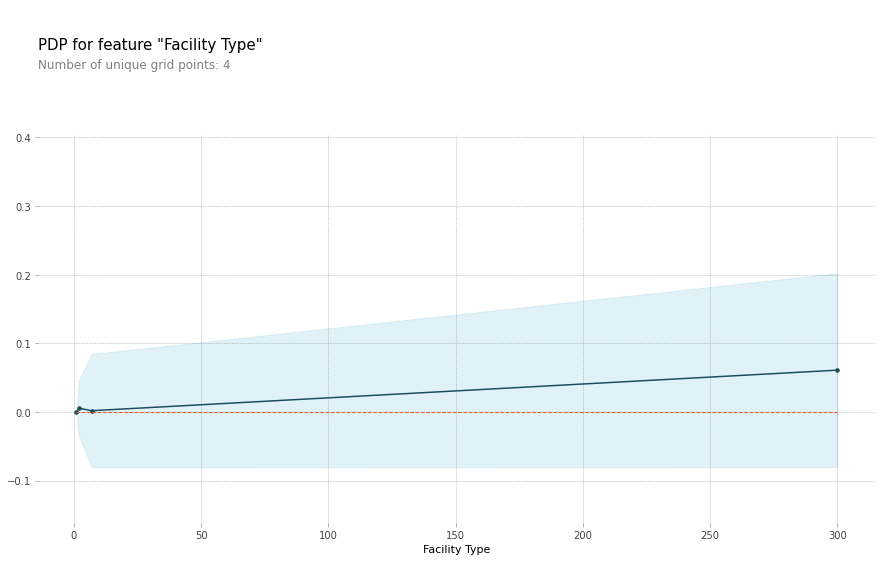

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot

feature ='Facility Type'

pdp_dist = pdp.pdp_isolate(model = rdc, dataset = x_train_encoded, model_features= features, feature = feature)
pdp.pdp_plot(pdp_dist, feature);

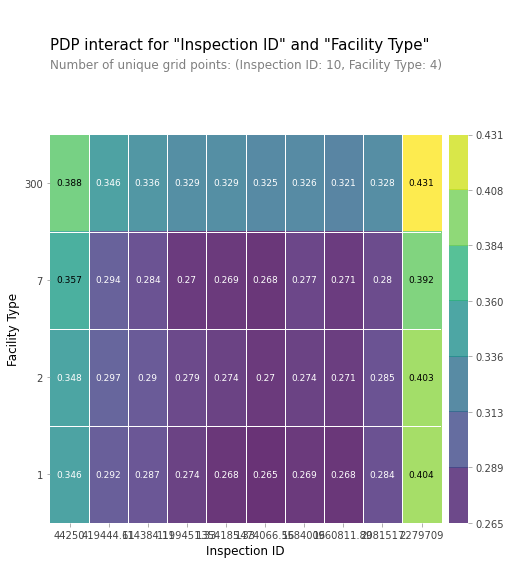

In [26]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Inspection ID', 'Facility Type']

interaction = pdp_interact(
    model = rdc,
    dataset = x_train_encoded,
    model_features = x_train_encoded.columns,
    features = features
)

pdp_interact_plot(interaction, plot_type = 'grid', feature_names = features);

In [16]:
row = X_test.iloc[[0]]
row

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,year_recorded,month_recorded,day_recorded,lat_long
0,114835,7 - ELEVEN,46907.0,Grocery Store,Risk 2 (Medium),600 S DEARBORN,CHICAGO,IL,60605.0,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874481,-87.629357,2011,3,22,"41.87448116568133,-87.62935653990546"


In [17]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = process.transform(row)
shap_values = explainer.shap_values(row_processed)


shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = row,
    link = 'logit'
)